<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the Conditional Auto-Encoder with the settings obtained from Optimization


In [1]:
import tensorflow as tf
tf.__version__
tf.config.list_physical_devices('GPU')


import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import logging
import sys
from sklearn import preprocessing
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Reshape, LeakyReLU, BatchNormalization, Dense, Flatten, Input,Dropout
import random
import numpy as np
import pickle

In [2]:
SMALL_SIZE =  14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [3]:
RUN             = '1'

seeds           = {'1':5123, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div_spec_norm'


plotpath        = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'


if conditional:
    label_2='conditional_%s'%cond_on+label_2

In [4]:
train_,valid_,test_,le = pickle.load(open(os.path.join(root_model_data,'combined_%s_new_relabeled.pkl'%label_),'rb'))

In [5]:
train, valid, test, mean, std = np.load(os.path.join(root_decoded,'decoded_%s_RUN%s_new.npy'%(label_2,RUN)), allow_pickle=True)

In [6]:
path = os.path.join(root_models,'encoder_%s_run%s_new'%(label_2, RUN))
encoder = tf.keras.models.load_model(path)
path = os.path.join(root_models,'decoder_%s_run%s_new'%(label_2, RUN))
decoder = tf.keras.models.load_model(path)

In [7]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_27 (Flatten)         (None, 1000)              0         
_________________________________________________________________
spectral_normalization_16 (S (None, 215)               215430    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 215)               0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 215, 1)            0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 215)               0         
_________________________________________________________________
spectral_normalization_17 (S (None, 10)                2170      
_________________________________________________________________
reshape_8 (Reshape)          (None, 10, 1)             0

In [8]:
decoder.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_29 (Flatten)         multiple                  0         
_________________________________________________________________
dense_29 (Dense)             multiple                  2365      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   multiple                  0         
_________________________________________________________________
reshape_9 (Reshape)          multiple                  0         
_________________________________________________________________
flatten_30 (Flatten)         multiple                  0         
_________________________________________________________________
dense_30 (Dense)             multiple                  216000    
Total params: 218,365
Trainable params: 218,365
Non-trainable params: 0
_______________________________________________

In [9]:
input = Input((1000,1))

x = encoder(input)
x = decoder(x)

AE_2 = Model(input,x)

In [10]:
AE_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1000, 1)]         0         
_________________________________________________________________
sequential (Sequential)      (None, 10)                217600    
_________________________________________________________________
sequential_18 (Sequential)   (None, 1000)              218365    
Total params: 435,965
Trainable params: 435,740
Non-trainable params: 225
_________________________________________________________________


In [11]:
random.seed(seeds[RUN])
np.random.seed(seeds[RUN])
tf.random.set_seed(seeds[RUN])

In [12]:
opt = tf.keras.optimizers.Adam
lr  = learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(1e-3,20000,5e-5,power=0.5, cycle=False) 
AE_2.compile(loss='mean_squared_error', metrics='mean_squared_error', optimizer=opt(lr))

In [13]:
AE_2.fit(x=np.expand_dims(train,-1), y=np.expand_dims(train,-1),validation_data=(np.expand_dims(valid,-1),np.expand_dims(valid,-1)), epochs=55, batch_size=25)

Epoch 1/55
8379/8379 [==============================] - 14s 2ms/step - loss: 0.0928 - mean_squared_error: 0.0928 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 2/55
8379/8379 [==============================] - 14s 2ms/step - loss: 0.0608 - mean_squared_error: 0.0608 - val_loss: 0.0263 - val_mean_squared_error: 0.0263
Epoch 3/55
8379/8379 [==============================] - 14s 2ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 4/55
8379/8379 [==============================] - 14s 2ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 5/55
8379/8379 [==============================] - 14s 2ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 6/55
8379/8379 [==============================] - 14s 2ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 7/55

In [14]:
predict = AE_2.predict(valid)

In [15]:
latent_dim=10

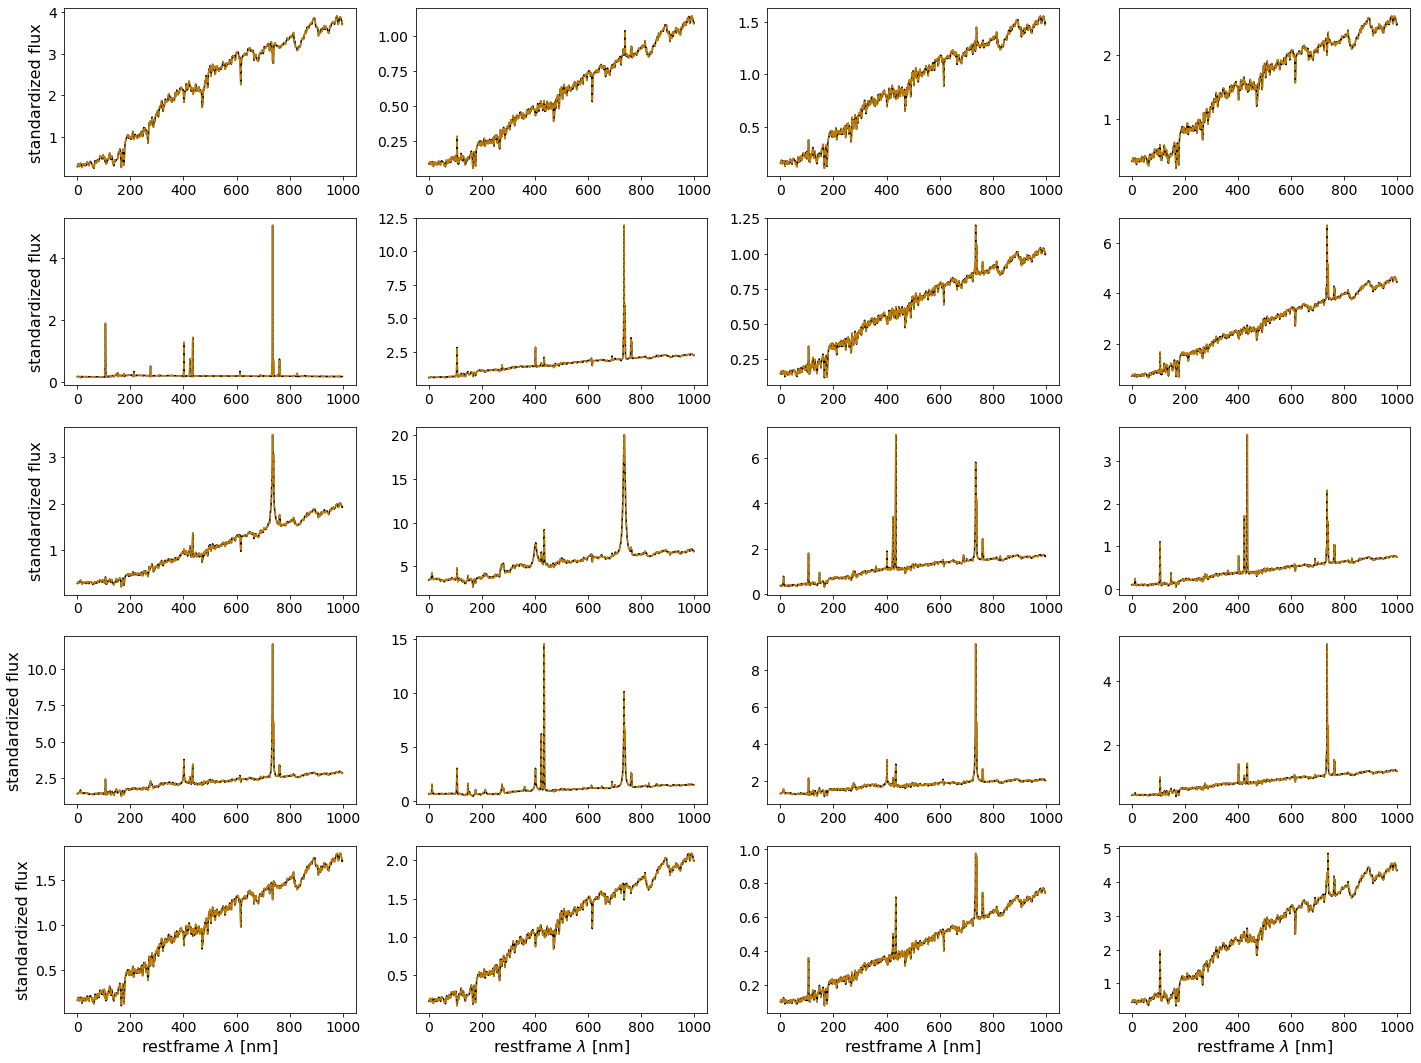

In [16]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.

fig, ax = plt.subplots(5,4, figsize=(20,15))
ax = ax.flatten()
for nn, ii in enumerate(np.arange(20)):
    if ii<16:
        jj = 0
    else:
        jj = 1
    ind = (test_['new_label']==(nn%16))
    #print(sum(ind))
    ax[nn].plot(test[ind][jj], color='k')
    ax[nn].plot(test[ind][jj], color='orange', ls='--',alpha=0.75)
    if nn in [16,17,18,19]:
        ax[ii].set_xlabel(r'restframe $\lambda$ [nm]')
    if ii%4==0:
        ax[ii].set_ylabel(r'standardized flux')    
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'reconstructions_test_AE2_spec_norm.pdf'), bbox_inches='tight')
plt.show()

In [17]:
wlmin, wlmax    = (3388,8318)
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [18]:
loss = np.mean((valid-predict)**2,axis=0)

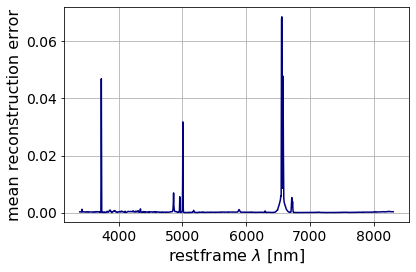

In [19]:
plt.plot(new_wl[:-1],loss,color='navy')
plt.xlabel(r'restframe $\lambda$ [nm]')
plt.ylabel('mean reconstruction error')
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'mean_reconstruction_error_AE2_spec_norm.pdf'), bbox_inches='tight')

In [21]:
path = os.path.join(root_models,'full_ae_model_%s_run%s_denoised_inpainted'%(label_2,RUN))
AE_2.save(path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/full_ae_model_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div_spec_norm_run1_denoised_inpainted/assets


In [11]:
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        new_model.add(curr_layer)
    return new_model

In [23]:
encoder = extract_layers(AE_2,0,2)
encoder.build((None,fixed_num_bins,1))
encoder.summary()

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x2aaba852c3a0>
1 <tensorflow.python.keras.engine.sequential.Sequential object at 0x2aaba8502970>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 10)                217600    
Total params: 217,600
Trainable params: 217,375
Non-trainable params: 225
_________________________________________________________________


In [24]:
encoded_valid = encoder.predict(valid)
encoded_train = encoder.predict(train)
encoded_test  = encoder.predict(test)

In [25]:
path = os.path.join(root_encoded,'encoder_AE2_%s_run%s_inpainted_denoised'%(label_2, RUN))
encoder.save(path)

INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Datasets/encoded/sdss/encoder_AE2_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div_spec_norm_run1_inpainted_denoised/assets


In [26]:
encoded_valid = np.squeeze(encoded_valid)
encoded_train = np.squeeze(encoded_train)
encoded_test  = np.squeeze(encoded_test)
np.save(os.path.join(root_encoded,'encoded_AE2_%s_RUN%s.npy'%(label_2,RUN)),[encoded_train, encoded_valid, encoded_test])


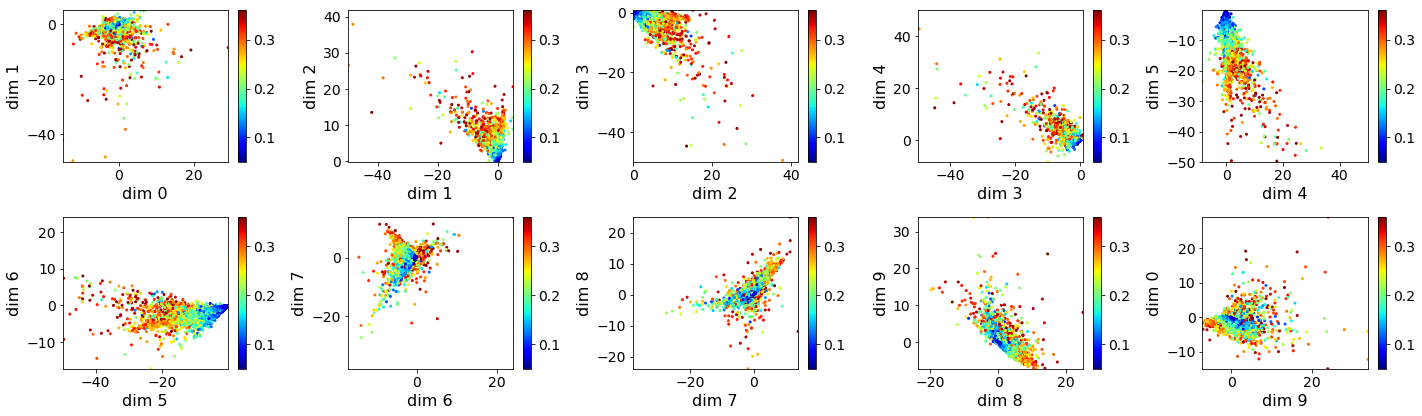

In [27]:
lims = 50

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid_['z'], cmap='jet',s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_redshift_AE2_spec_norm.pdf'), bbox_inches='tight')
plt.show()


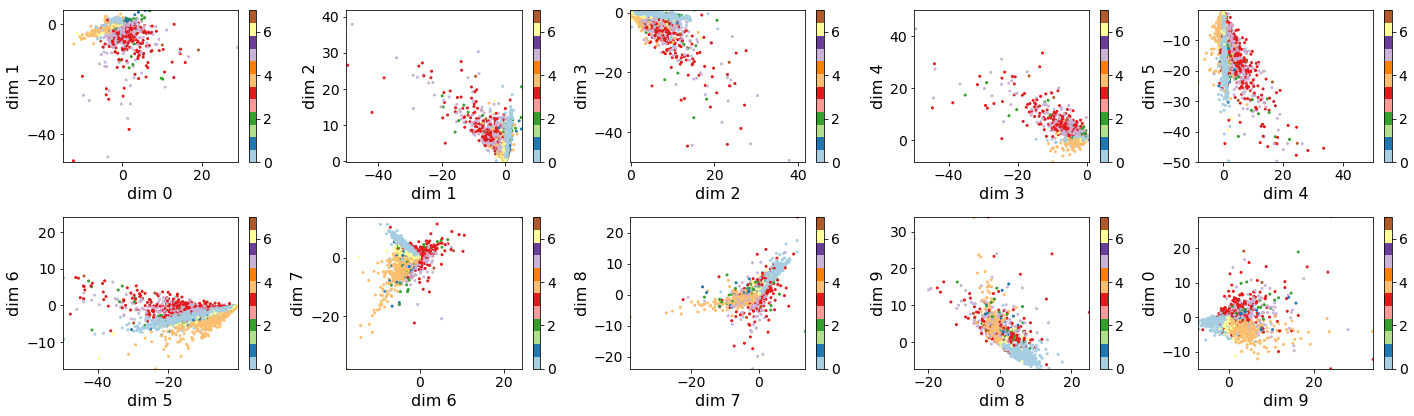

In [28]:
lims = 50

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid_['subclass'], cmap='Paired', s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_subclass_AE2_spec_norm.pdf'), bbox_inches='tight')
plt.show()


In [9]:
from tensorflow import keras

AE_2 = keras.models.load_model(os.path.join(root_models,'full_ae_model_%s_run%s_denoised_inpainted'%(label_2,RUN)))

In [13]:
AE_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1000, 1)]         0         
_________________________________________________________________
sequential (Sequential)      (None, 10)                217600    
_________________________________________________________________
sequential_18 (Sequential)   (None, 1000)              218365    
Total params: 435,965
Trainable params: 435,740
Non-trainable params: 225
_________________________________________________________________


In [18]:
decoder = extract_layers(AE_2,2,3)
decoder.build(input_shape=(None,10,1))
decoder.summary()

2 <tensorflow.python.keras.engine.sequential.Sequential object at 0x2aae3f8506a0>
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_18 (Sequential)   (None, 1000)              218365    
Total params: 218,365
Trainable params: 218,365
Non-trainable params: 0
_________________________________________________________________


In [19]:
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_AE2_%s_RUN%s.npy'%(label_2,RUN)), allow_pickle=True)




In [20]:
decoder.predict(encoded_train)

array([[0.58248615, 0.5698502 , 0.58860683, ..., 3.4458642 , 3.404356  ,
        3.4429083 ],
       [0.10338122, 0.09658279, 0.09957685, ..., 0.24967307, 0.24226916,
        0.244667  ],
       [0.22954121, 0.21971038, 0.22632508, ..., 1.8452803 , 1.8155532 ,
        1.8248587 ],
       ...,
       [0.2444394 , 0.23438403, 0.24110337, ..., 1.7247647 , 1.6973114 ,
        1.7048708 ],
       [0.02993689, 0.02487949, 0.03331997, ..., 0.2186061 , 0.2145128 ,
        0.2183789 ],
       [0.3957257 , 0.3976089 , 0.3989715 , ..., 3.8444953 , 3.7892637 ,
        3.8080204 ]], dtype=float32)

In [15]:
# x, logps = np.load('optimization_results.npy', allow_pickle=True)

# logps=np.asarray(logps).reshape((5,16))

# x=np.asarray(x).reshape((5,15,10,1))
# print(x.shape)

# for ii in range(5):
#     plt.plot(decoder(x[ii,0:1]).numpy()[0],color='navy',label='logp=%.1f'%-logps[ii,0])
#     plt.plot(decoder(x[ii,-1::]).numpy()[0],alpha=0.8,color='gold',label='logp=%.1f'%-logps[ii,-1])
#     plt.legend()
#     plt.show()

In [16]:
# x, logps = np.load('optimization_results_long.npy', allow_pickle=True)

# logps=np.asarray(logps).reshape((2,31))

# x=np.asarray(x).reshape((2,30,10,1))
# print(x.shape)

# for ii in range(2):
#     plt.plot(decoder(x[ii,0:1]).numpy()[0],color='navy',label='logp=%.1f'%-logps[ii,0])
#     plt.plot(decoder(x[ii,-1::]).numpy()[0],alpha=0.8,color='gold',label='logp=%.1f'%-logps[ii,-1])
#     plt.legend()
#     plt.show()

In [21]:
path = os.path.join(root_decoded,'decoder_AE2_%s_run%s_inpainted_denoised'%(label_2, RUN))
decoder.save(path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Datasets/decoded/sdss/decoder_AE2_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div_spec_norm_run1_inpainted_denoised/assets


In [22]:
decoded_train = AE_2.predict(train)
decoded_valid = AE_2.predict(valid)
decoded_test  = AE_2.predict(test)

In [23]:
np.save(os.path.join(root_decoded,'decoded_AE2_%s.npy'%(label_2)),[decoded_train,decoded_valid, decoded_test, mean, std])

In [19]:
label_2

'galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected_mean_div'